# 2013TSA Phenotype ML Modeling

### Predict behavioral elimination using 2013 TSA phenotype scores

Alex Eyre (2023)

____
### Define Functions; Package Import

In [1]:
def remcols(table,indices):
    for idx in indices:
        table = table[table[idx] != "Not Recorded"]
    return table

In [2]:
def histplots(data, idx_list, ax_idx):
    bins_list = [1,2,3,4,5,6]
    i         = 0     
    nrow      = 0
    ncol      = 0
    
    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data.columns):
                break
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i].dropna(),
                                    bins    = bins_list,
                                    range   = (1,6),
                                    alpha   = 0.5,
                                    color   = "blue",
                                    density = True)
            ax_idx[nrow, ncol].set_title(idx_list[i])
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1

In [3]:
def normplots(data, idx_list, ax_idx):
    i         = 0     
    nrow      = 0
    ncol      = 0
    
    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data.columns):
                break
            
            bins_list = [0,1,2,3,4,5]
            max_val   = max(data.iloc[:,i].dropna())
            min_val   = min(data.iloc[:,i].dropna())
            step_size  = (max_val - min_val) / 5
            bins_list = [min_val + (x * step_size) for x in bins_list]         # "List Comprehension"
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i].dropna(),
                                    bins    = bins_list,
                                    range   = (min_val, max_val),
                                    alpha   = 0.5,
                                    color   = "blue",
                                    density = True)
            
            ax_idx[nrow, ncol].set_title(idx_list[i])
            
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1

In [4]:
def compareplots(data, idx_list, ax_idx):
    bins_list = [1,2,3,4,5,6]
    i         = 1     
    nrow      = 0
    ncol      = 0
    
    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data.columns):
                break
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i][data["BehElim"] == 0],
                                    bins    = bins_list,
                                    range   = (0,6),
                                    alpha   = 0.5,
                                    color   = "blue",
                                    density = True)
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i][data["BehElim"] == 1],
                                    bins    = bins_list,
                                    range   = (0,6),
                                    alpha   = 0.5,
                                    color   = "orange",
                                    density = True)  
                
            ax_idx[nrow, ncol].set_title(idx_list[i-1])
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1

In [5]:
def makelabels(labels):
    i = 0
    while i < len(labels):
        if labels[i] == 0:
            labels[i] = "Accepted"
        else:
            labels[i] = "Eliminated"
        i = i + 1
    return labels

In [6]:
def bootstrap_FS(X, y, num_bs):
    
    fs_data = []  
    i = 0
    while i < num_bs:
        curr_data = []
        
        rf = RandomForestClassifier(random_state = i)
        rfecv = RFECV(
            estimator = rf,
            step = 1,
            cv = None,
            scoring = "accuracy",
            min_features_to_select = 1
        )
        
        rfecv.fit(X, list(y))
        fs_data = fs_data + list(X.columns[rfecv.support_])
        i = i + 1
    
    return(fs_data)

In [7]:
def NBC(X, y, count):
    
    curr_list = []
    i = 0
    while i < count:
        X1_train, X1_test, y1_train, y1_test = train_test_split(X, 
                                                            y,
                                                            test_size = 0.30,
                                                            random_state = i)
        gnb_model1  = GaussianNB()
        y_pred      = gnb_model1.fit(X1_train, y1_train).predict(X1_test)
        curr_list.append((1 - (y1_test != y_pred).sum()/ X1_test.shape[0]))
        i = i + 1
    return(curr_list)

In [8]:
def RF(X, y, count):
    
    curr_list = []
    i = 0
    while i < count:
        X1_train, X1_test, y1_train, y1_test = train_test_split(X, 
                                                            y,
                                                            test_size = 0.30,
                                                            random_state = i)
        rfc_model1  = RandomForestClassifier(n_estimators = 100)
        rfc_model1.fit(X1_train, y1_train)
        rfc_pred1   = rfc_model1.predict(X1_test)
        curr_list.append((1 - (y1_test != rfc_pred1).sum()/ X1_test.shape[0]))
        i = i + 1
    return(curr_list)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import pi
from collections import Counter
import time

# Radar Plots
import plotly.graph_objects as go

# Classification Tasks
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import GaussianNB

# Prediction Tasks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.style.use('seaborn-darkgrid')

C:\Users\aweyr\AppData\Local\Temp\ipykernel_27456\3151467755.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


____
### Data Import + Cleanup

In [10]:
M03 = pd.read_excel("M03.xlsx")
M06 = pd.read_excel("M06.xlsx")
M09 = pd.read_excel("M09.xlsx")
M12 = pd.read_excel("M12.xlsx")

In [11]:
# First set of indices contain behavioral elimination, second do not
Env_Idx        = ["BehElim", "Confidence", "Concentration", "Responsiveness", "Initiative",
                  "Excitability", "Hearing Sensitivity", "Body Sensitivity", "CR", "IP", "PP"]
Test_Idx       = ["BehElim", "CR.1", "MP", "PP.1", "IP.1", "HG", "H1", "H2", "ACT"]

Env_Idx1       = ["Confidence", "Concentration", "Responsiveness", "Initiative",
                  "Excitability", "Hearing Sensitivity", "Body Sensitivity", "CR", "IP", "PP"]
Test_Idx1      = ["CR.1", "MP", "PP.1", "IP.1", "HG", "H1", "H2", "ACT"]

In [12]:
# Remove dogs from the tests if they contain missing information
M03_Env       = remcols(M03[Env_Idx].dropna(), Env_Idx1)
M03_Test      = remcols(M03[Test_Idx].dropna(), Test_Idx1)
M06_Env       = remcols(M06[Env_Idx].dropna(), Env_Idx1) 
M06_Test      = remcols(M06[Test_Idx].dropna(), Test_Idx1)
M09_Env       = remcols(M09[Env_Idx].dropna(), Env_Idx1)
M09_Test      = remcols(M09[Test_Idx].dropna(), Test_Idx1)
M12_Env       = remcols(M12[Env_Idx].dropna(), Env_Idx1)
M12_Test      = remcols(M12[Test_Idx].dropna(), Test_Idx1)

In [13]:
# Foward Sequential Combined Scores
M3_Comb       = pd.merge(M03_Env, M03_Test[Test_Idx1], left_index = True, right_index = True)
M36_Comb      = pd.merge(M3_Comb, pd.merge(M06_Env[Env_Idx1], M06_Test[Test_Idx1], left_index = True, right_index = True), left_index = True, right_index = True)
M369_Comb     = pd.merge(M36_Comb, pd.merge(M09_Env[Env_Idx1], M09_Test[Test_Idx1], left_index = True, right_index = True), left_index = True, right_index = True)
M36912_Comb   = pd.merge(M369_Comb, pd.merge(M12_Env[Env_Idx1], M12_Test[Test_Idx1], left_index = True, right_index = True), left_index = True, right_index = True)

# Forward Sequential Individual Tests for comparison
M36_Env       = pd.merge(M03_Env, M06_Env[Env_Idx1], left_index = True, right_index = True)
M369_Env      = pd.merge(M36_Env, M09_Env[Env_Idx1], left_index = True, right_index = True)
M36912_Env    = pd.merge(M369_Env, M12_Env[Env_Idx1], left_index = True, right_index = True)
M36_Test      = pd.merge(M03_Test, M06_Test[Test_Idx1], left_index = True, right_index = True)
M369_Test     = pd.merge(M36_Test, M09_Test[Test_Idx1], left_index = True, right_index = True)
M36912_Test   = pd.merge(M369_Test, M12_Test[Test_Idx1], left_index = True, right_index = True)

C:\Users\aweyr\AppData\Local\Temp\ipykernel_27456\27247862.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Excitability_x', 'Confidence_x', 'Hearing Sensitivity_x', 'H2_x', 'CR_x', 'MP_x', 'IP.1_x', 'ACT_x', 'PP_x', 'IP_x', 'PP.1_x', 'CR.1_x', 'Responsiveness_x', 'HG_x', 'Body Sensitivity_x', 'Initiative_x', 'H1_x', 'Concentration_x'} in the result is deprecated and will raise a MergeError in a future version.
  M36912_Comb   = pd.merge(M369_Comb, pd.merge(M12_Env[Env_Idx1], M12_Test[Test_Idx1], left_index = True, right_index = True), left_index = True, right_index = True)
C:\Users\aweyr\AppData\Local\Temp\ipykernel_27456\27247862.py:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Excitability_x', 'Confidence_x', 'Hearing Sensitivity_x', 'CR_x', 'PP_x', 'IP_x', 'Responsiveness_x', 'Body Sensitivity_x', 'Initiative_x', 'Concentration_x'} in the result is deprecated and will raise a MergeError in a future version.
  M36912_Env    = pd.merge(M

### Visualization
#### Relative Frequency Histograms
Blue   = Accepted

Orange = Eliminated for Behavioral Reasons

#### Environment Tests

In [14]:
data_env    = M03_Env

<bound method Figure.tight_layout of <Figure size 1500x600 with 10 Axes>>

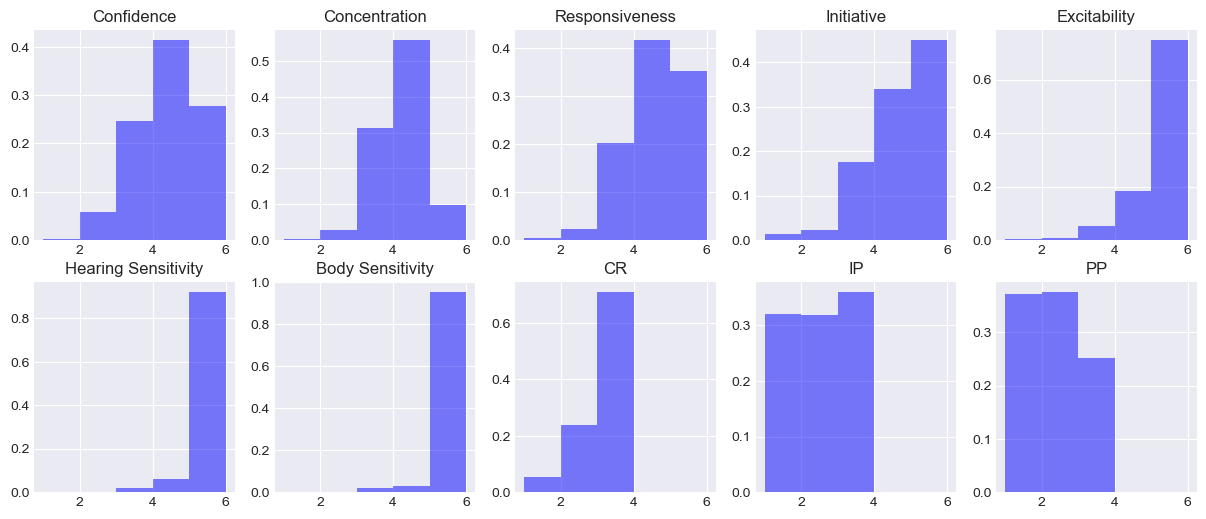

In [15]:
# Histogram Plots of All Dogs
ax_idx = []
for i in np.arange(0,len(Env_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Env_Idx1)/5)),
                             ncols = 5,
                             figsize = (15,6))
histplots(data_env[Env_Idx1], Env_Idx1, ax_idx)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1500x600 with 10 Axes>>

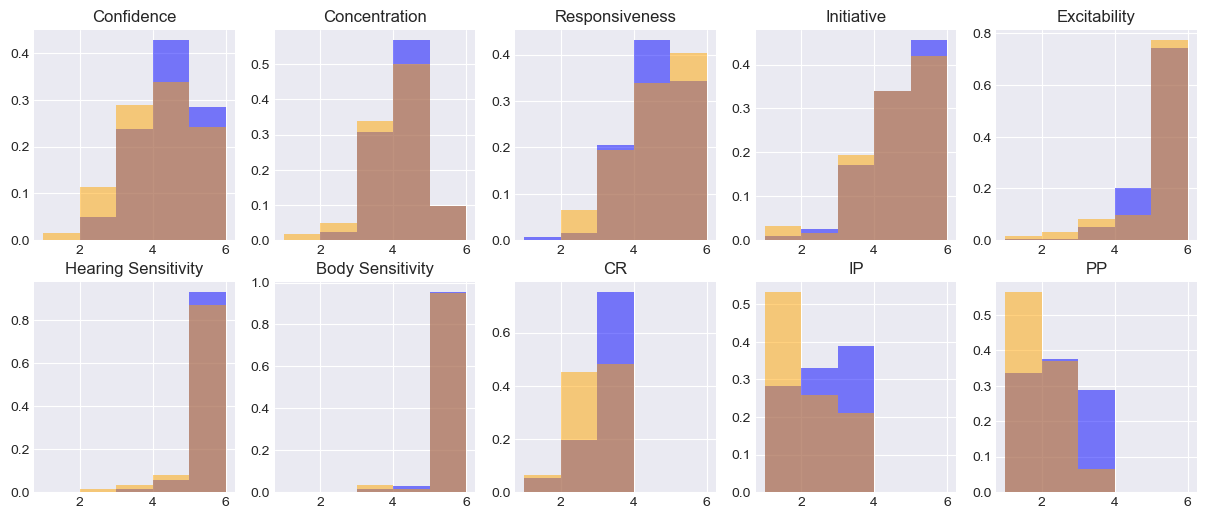

In [16]:
# Histogram Plots of All Dogs Colorized by BehElim Status
ax_idx = []
for i in np.arange(0,len(Env_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Env_Idx1)/5)),
                             ncols = 5,
                             figsize = (15,6))
compareplots(data_env, Env_Idx1, ax_idx)
fig.tight_layout

#### Airport Terminal Tests

In [17]:
data_test   = M03_Test

<bound method Figure.tight_layout of <Figure size 1500x600 with 8 Axes>>

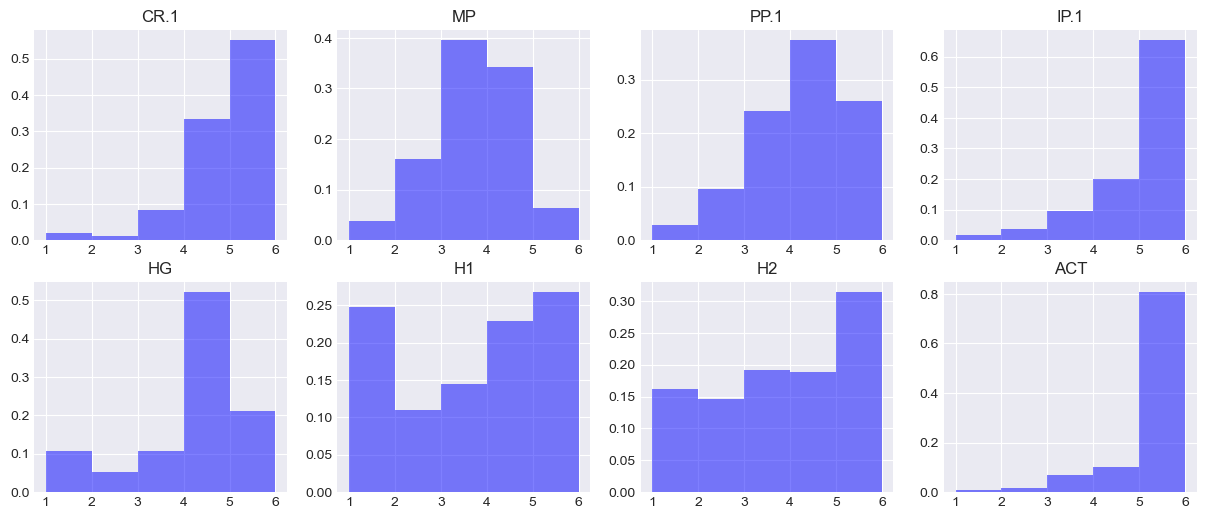

In [18]:
# Histogram Plots of All Dogs
ax_idx = []
for i in np.arange(0,len(Test_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Test_Idx1)/4)),
                             ncols = 4,
                             figsize = (15,6))
histplots(data_test[Test_Idx1], Test_Idx1, ax_idx)
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1500x600 with 8 Axes>>

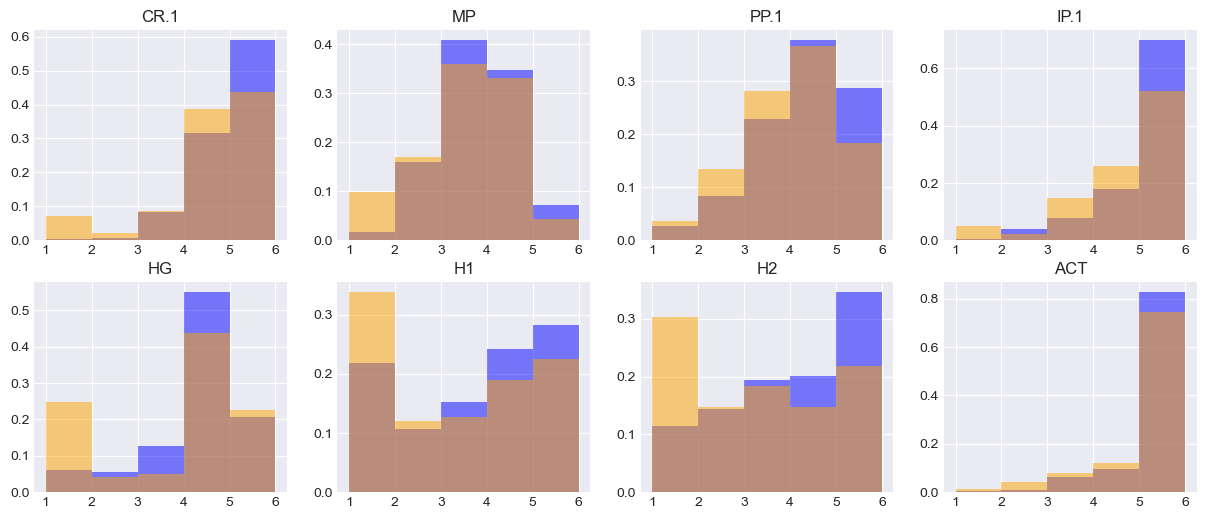

In [19]:
# Histogram Plots of All Dogs Colorized by BehElim Status
ax_idx = []
for i in np.arange(0,len(Test_Idx1),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(Test_Idx1)/4)),
                             ncols = 4,
                             figsize = (15,6))
compareplots(data_test, Test_Idx1, ax_idx)
fig.tight_layout

#### Radar Plots

In [20]:
test_input = "Test"              # Test or Env
elim_status1 = 0                # 0 for accepted, 1 for eliminated
elim_status2 = "Accepted"     # Accepted or Eliminated

# Do not need to edit
categories = globals()["%s_Idx1" % test_input]
indices = ["M03", "M06", "M09", "M12"]

In [21]:
# Build Data Table
df = pd.DataFrame(np.zeros((len(indices),len(categories))), index = indices, columns = categories)
dtables = ["M03_%s" % test_input, "M06_%s" % test_input, "M09_%s" % test_input, "M12_%s" % test_input]


for category in categories:
    i = 0
    for indx in indices:
        df[category][indx] = np.mean(globals()[dtables[i]][globals()[
                                 dtables[i]]["BehElim"] == elim_status1][category].dropna())
        i = i + 1

In [22]:
# Rename categories for airport terminal test for cleaned up figure
# DO NOT RUN IF VISUALIZING THE ENVIRONMENTAL TESTS

categories = ["CR", "MP", "PP", "IP", "HG", "H1", "H2", "ACT"]

In [23]:
# Radar Plot Values
N          = len(categories)

angles     = [n / float(N) * 2 * pi for n in range(N)]
angles    += angles[:1]

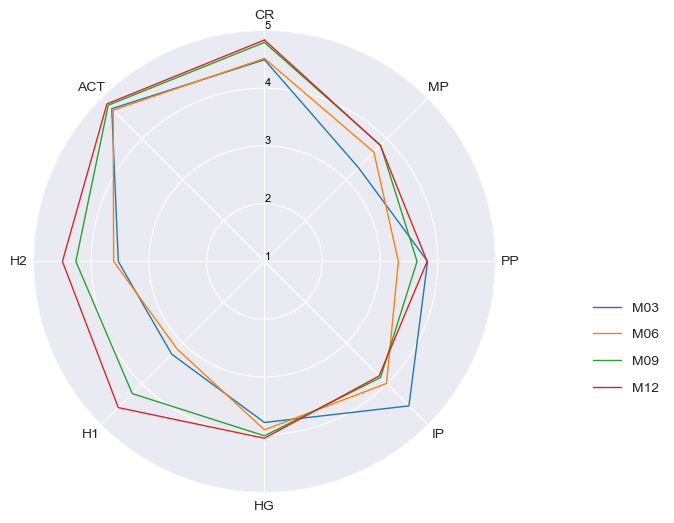

In [24]:
# Initialize Radar Plot
fig         = plt.figure(figsize = (6, 6))
ax          = plt.subplot(111, polar = True)

# Set First Point on Top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Set N axes + labels
plt.xticks(angles[:-1], categories)

# Draw y labels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5], 
           ["1","2","3","4","5"], 
           color = "black", 
           size = 8)
plt.ylim(1,5)

# Fill out Radar Plot
i           = 0
while i < len(df):
    values = df.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=indices[i])
    ax.fill(angles, values, 'b', alpha=0.0)
    i = i + 1  
    
ax.legend(
    loc = (1.2,0.2),
    labelspacing = 1.0,
    frameon = False)

plt.savefig("Legend.png", format = "png", dpi = 800, bbox_inches = "tight")
plt.show()

### Machine Learning

#### Choose Dataset

In [25]:
X           = M03_Test

y           = X["BehElim"]
X           = X.drop("BehElim", axis = 1)
beh_labels  = makelabels(list(y))

In [26]:
# Make Training/Testing (70/30%) Datasets for Single Tests
X1_train, X1_test, y1_train, y1_test = train_test_split(X, 
                                                        y,
                                                        test_size = 0.30,
                                                        random_state = 101)

### Classification

#### Principal Component Analysis

In [27]:
# Run PCA
pca         = PCA(n_components = len(X.columns))
pca.fit(X)
X_pca       = pca.transform(X)
components  = pca.fit_transform(X[list(X.columns)])

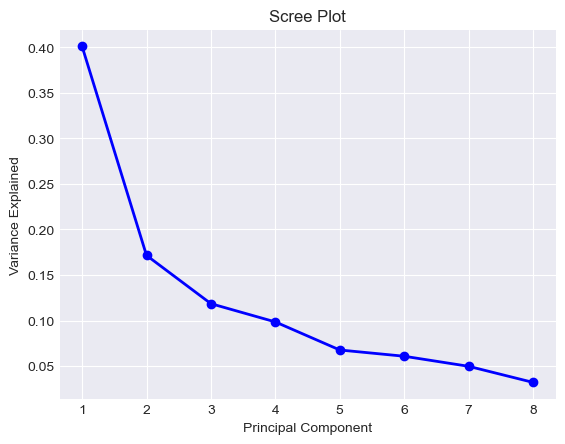

In [28]:
# Scree Plot
PC_values   = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [29]:
# Find the top two components for plotting PC1 vs. PC2
i           = 0
PC1         = []
PC2         = []
while i < len(X_pca):
    PC1.append(X_pca[i][0])
    PC2.append(X_pca[i][1])
    i = i + 1

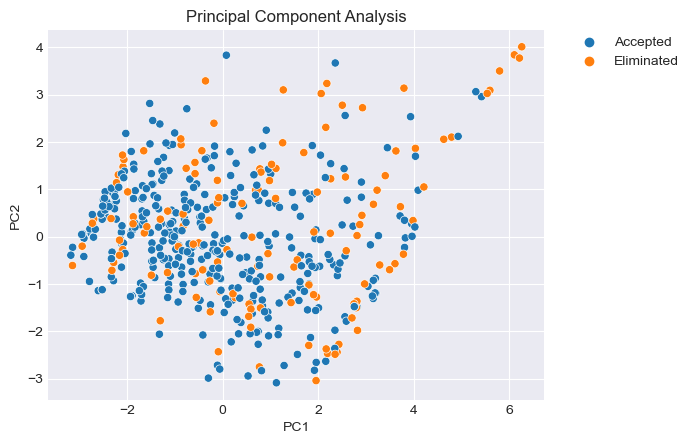

In [30]:
# Plot the top two components against eachother
sns.scatterplot(x = PC1, 
                y = PC2, 
                hue = beh_labels)
plt.title("Principal Component Analysis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

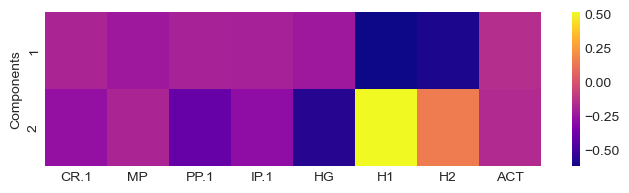

In [31]:
# Heatmap of top 2 principal components using relative strength of traits
df_comp     = pd.DataFrame(pca.components_,columns=X.columns)
df_comp.index = np.arange(1,len(components[0])+1)

df_comp     = df_comp.iloc[np.arange(0,2)]

plt.figure(figsize=(8,2))
sns.heatmap(df_comp,cmap='plasma').set(ylabel = "Components")
plt.show()

#### Naive Bayes Classification

In [32]:
# Run Gaussian Naive Bayes
gnb_model1  = GaussianNB()
y_pred      = gnb_model1.fit(X1_train, y1_train).predict(X1_test)

In [33]:
# Print Results
print("Total Points:\t\t%d" % X1_test.shape[0])
print("Mislabeled points:\t%d" % (y1_test != y_pred).sum())
print("Accuracy:\t\t%s" % (1 - (y1_test != y_pred).sum()/ X1_test.shape[0]))

Total Points:		170
Mislabeled points:	38
Accuracy:		0.7764705882352941


#### Random Forest Feature Selection

In [34]:
# Recursive Feature Elimination with Cross-Validation
rf          = RandomForestClassifier(random_state = 0)
rfecv       = RFECV(estimator = rf,
                    step = 1,
                    cv = None,
                    scoring = "accuracy",
                    min_features_to_select = 1)

In [35]:
# Single RFC run
start_time  = time.time()
rfecv.fit(X, list(y))
print("Optimal number of features : %d" % rfecv.n_features_)
print("Features:\t\t%s" % " ".join(list(X.columns[rfecv.support_])))
print("Time in seconds:\t%s" % (time.time() - start_time))
print("Minutes for 1000 runs:\t%s" % (((time.time() - start_time) * 1000) / 60))

Optimal number of features : 1
Features:		HG
Time in seconds:	4.561340808868408
Minutes for 1000 runs:	76.02234681447347


In [36]:
# Bootstrapped RFC runs
#num_runs = 250

#start_time = time.time()
#bootstrap_data = bootstrap_FS(X, y, num_runs)
#print("Seconds:\t%s" % (time.time() - start_time))
#print("Traits:\t\t%s" % list(Counter(bootstrap_data).keys()))
#print("Percentages:\t%s" % [x / num_runs for x in list(Counter(bootstrap_data).values())])

### Prediction

#### Logistic Regression

In [37]:
# Run Logistic Regression
log_model1  = LogisticRegression()
log_model1.fit(X1_train,y1_train)
log_pred1   = log_model1.predict(X1_test)

In [38]:
print(classification_report(y1_test,log_pred1))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       131
           1       0.58      0.18      0.27        39

    accuracy                           0.78       170
   macro avg       0.69      0.57      0.57       170
weighted avg       0.75      0.78      0.73       170



In [39]:
logit_roc_auc = roc_auc_score(y1_test, log_model1.predict(X1_test))
print("AUC: %s" % logit_roc_auc)

AUC: 0.5706596202779409


#### Support Vector Machines

In [40]:
# Run SVM
svc_model1  = SVC()
svc_model1.fit(X1_train,y1_train)
svc_pred1   = svc_model1.predict(X1_test)

In [41]:
print(classification_report(y1_test,svc_pred1))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       131
           1       0.62      0.13      0.21        39

    accuracy                           0.78       170
   macro avg       0.71      0.55      0.54       170
weighted avg       0.75      0.78      0.72       170



In [42]:
svc_roc_auc = roc_auc_score(y1_test, svc_model1.predict(X1_test))
print("AUC: %s" % svc_roc_auc)

AUC: 0.5526521824231747


In [43]:
# Run Parameter Search to attempt to find settings that improve results
param_grid  = {'C': [0.01,0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid1       = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid1.fit(X1_train, y1_train)
grid_pred1  = grid1.predict(X1_test)

In [44]:
print(classification_report(y1_test, grid_pred1))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       131
           1       0.62      0.13      0.21        39

    accuracy                           0.78       170
   macro avg       0.71      0.55      0.54       170
weighted avg       0.75      0.78      0.72       170



In [45]:
svc_roc_auc = roc_auc_score(y1_test, grid1.predict(X1_test))
print("AUC: %s" % svc_roc_auc)

AUC: 0.5526521824231747


####  Random Forest

In [46]:
# Run Random Forest
rfc_model1  = RandomForestClassifier(n_estimators = 100)
rfc_model1.fit(X1_train, y1_train)
rfc_pred1   = rfc_model1.predict(X1_test)

In [47]:
print(classification_report(y1_test, rfc_pred1))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       131
           1       0.43      0.26      0.32        39

    accuracy                           0.75       170
   macro avg       0.62      0.58      0.59       170
weighted avg       0.72      0.75      0.73       170



In [48]:
rfc_roc_auc = roc_auc_score(y1_test, rfc_model1.predict(X1_test))
print("AUC: %s" % rfc_roc_auc)

AUC: 0.578586807594441


### Random Forest Replicates and Z-Test

In [49]:
# Run Replicate Gaussian Naive Bayes
#curr_nbc    = NBC(X, y, 2500)
#print("Mean:\t%s" % np.mean(curr_nbc))
#print("Std:\t%s" % np.std(curr_nbc))

In [50]:
# Run Replicate Random Forest
#start_time  = time.time()
#curr_RF     = RF(X, y, 2500)
#print("Mean:\t%s" % np.mean(curr_RF))
#print("Std:\t%s" % np.std(curr_RF))
#print("--- %s seconds ---" % (time.time() - start_time))